# Medical Insurance Bills

In this project I will be working with a medical cost dataset. The data set contains information on indiviudal medical insurance bills, each bill has some demographics and perosnal charactersitics of the person who recieved it. For regression we are interested in how these characteristics are realted to total medical costs. The model will allow us to predict the medical costs, allowing hospitals to know their future revenue or atleast estimate it.

In [ ]:
import kagglehub
import os

# Download latest version
dataset_path = kagglehub.dataset_download("mirichoi0218/insurance")

# Find the CSV file within the downloaded directory
for filename in os.listdir(dataset_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(dataset_path, filename)
        break

print("Path to dataset file:", file_path)

Path to dataset file: /root/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1/insurance.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
insurance = pd.read_csv(file_path)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


array([[<Axes: title={'center': 'charges'}>]], dtype=object)

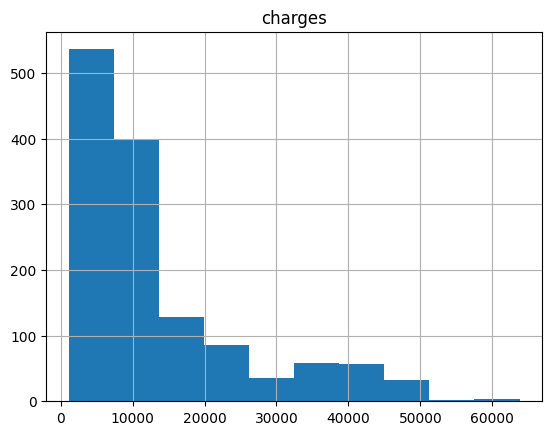

In [ ]:
insurance.hist('charges')

The charges historgram is right skewed, for our analysis we want it be centered so they results can be unbiased. Let's make a logarithimic scale for our charges.

array([[<Axes: title={'center': 'log_charges'}>]], dtype=object)

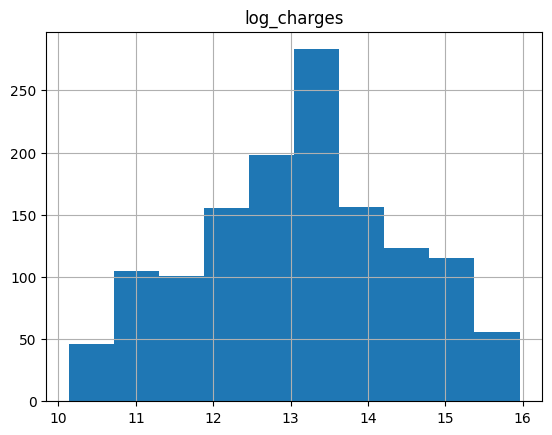

In [ ]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")

This is better!

Let's create a heat map to see the correlation between the features.

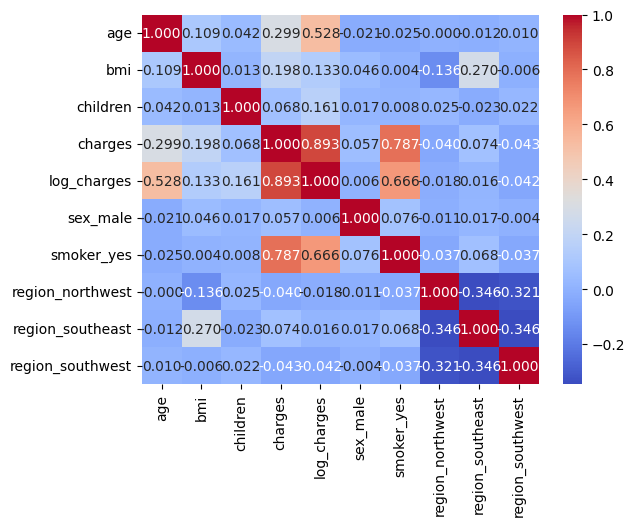

In [ ]:
insurance_copy = insurance.copy()
insurance_copy['log_charges'] = np.log2(insurance_copy['charges'])
insurance_copy = pd.get_dummies(insurance_copy, columns=['sex', 'smoker', 'region'], drop_first=True)
sns.heatmap(insurance_copy.corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.show()

Looking at the heatmap we can see some strong correlations with people who smoke. The charges feature heavily correlates with people who smoke, their age and thier bmi. Also, for some reason the southeast region highly correlates with BMI or body mass index. So keeping charges as our outcome or target variable I will be choosing Smoker_yes, age and BMI as the independant variables for our model. This makes sense since it has been proven that people who smoke, have a bad lifestyle, are old, or are overweight/obese have more health problems and therefore more medical costs.

In [ ]:
# build our train and test sets
X = insurance_copy[['smoker_yes', 'age', 'bmi']]
y = insurance_copy['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# build and fit our linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Now let's analyze how good the models is. First we need the model predictions to get the mean squared error.

In [ ]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.447919196329921


Also we can compare it to the mean squared error on the original scale

In [ ]:
print("Mean Squared Error on original scale:", np.exp(mse))

Mean Squared Error on original scale: 1.565052228580154


We can also find the R^2 value and coefficients of the model

In [ ]:
print("R^2 Score:", r2_score(y_train, y_pred))
print("Coefficients:", model.coef_)

R^2 Score: 0.743333600772825
Coefficients: [2.23214787 0.0508618  0.01563733]


We can see that the mean sqaure value is ~0.45 on the log scale and about ~1.6 on the original scale. The R^2 value is about 74%, meaning the model can explain 74% of log-charge variations. While the result is promising it is also optimistic since it is done on the training set. Next we will calculate the residuals to know more about the errors that don't fit.

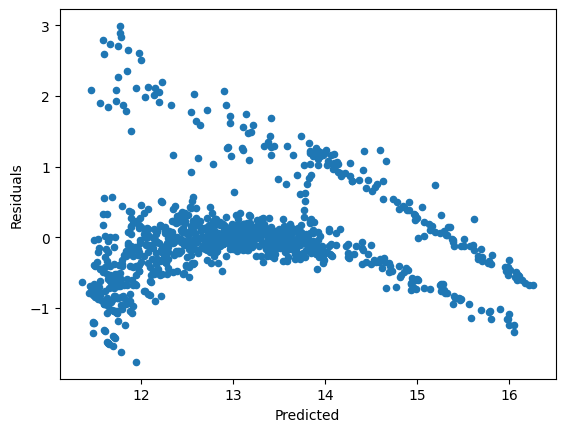

In [ ]:
fit_check = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred})
fit_check['Residuals'] = fit_check['Actual'] - fit_check['Predicted']
fit_check.plot.scatter(x='Predicted', y='Residuals')
plt.show()

Looking at the predicted and residual scatter plot it does suggest some vioalations. As the predicted or fitted values get larger the residual values drop. We expect it to be centered around zero. It does not make the model predictions unusable but it does question the linear regression assumptions we put up. The model seems to predict better with smaller values and worst with larger values, one could say it has a negative slope, when the slope should be zero. The smaller the predicted values the closer to residual value of zero it is. The model seems to be underestimating the values, therefore values are not centered around zero and stray away from zero as costs increase.

We are now going to look at the coefficients of each of the variables used to determine what they mean for hospitals in real world applications. The basic cost function used to determine this is as follow:

$$
Y_i = β_{0} + ∑_{i=1}^{N}β_{N}X_{N} + ϵ_i  \ (1.0)
$$
$$
β_{N} = \text{coefficients of determination}
$$
$$
X_{N} = \text{independent variables/predictors}
$$

In [ ]:
coefficients = model.coef_
independent_variables = X.columns

# Create a dictionary mapping independent variables to their coefficients
coef_dict = dict(zip(independent_variables, coefficients))

# Print the coefficients with their corresponding independent variables
for var, coef in coef_dict.items():
    print(f"{var}: {coef:.4f}")

var_dataframe = pd.DataFrame(coef_dict.items(), columns=['Variable', 'Coefficient'])
var_dataframe['percent change_normal'] = np.exp(var_dataframe['Coefficient']) * 100
var_dataframe

smoker_yes: 2.2321
age: 0.0509
bmi: 0.0156


,Variable,Coefficient,percent change_normal
0,smoker_yes,2.232148,931.986241
1,age,0.050862,105.217747
2,bmi,0.015637,101.576023


Looking at the table we can see that people who smoke have the highest percent change. Holding a constant BMI and age variable, we see a 2.23 increase in costs on the log scale, and omn a regular scale about ~932% increase. Age comes next, while holding BMI and smoker_yes constant we see a 0.05 increase which is about 105% increase on the regular scale. Finally holding smoker_yes and age constant we see 0.0156 increase in BMI with 101.6% increase on the regular scale. The y-intercept of the model has no meaning since it based on BMI, age ad smoker_yes variables, and we know that a patient cannot have a 0 age or 0 BMI. So there is bound to be no meaning to the y-intercept.

It's now time to see how the model performs on the test dataset. This will be a true test of the model's performance and see how overly optimistic the model is.

In [ ]:
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error on test set:", mse_test)
print("Mean Squared Error on test set on original scale:", np.exp(mse_test))
print("R^2 Score on test set:", r2_score(y_test, y_pred_test))

Mean Squared Error on test set: 0.4529281560931769
Mean Squared Error on test set on original scale: 1.5729111783706105
R^2 Score on test set: 0.7481369286464894


Not bad! we can see that on the test set the model performed pretty close to the trained set. The mse for the trained model wad about 0.447 and the for the test it is about 0.453 a difference of only 6E-03, very close indeed! The R^2 score for the trained model set was about 74.33% while for the test set it about 74.81% slightly better! Looking at the model we can say it perfomed well. Although the residual plot tells us that the model predicts much lower costs when patients were actually charged much higher. Therefore the model does need some tweaking for higher costs. We could base the model on different formula perhaps, maybe quadratic would fit more accurately? Let's check the residuals one last time on a Q-Q plot.

<ipython-input-17-9d9da1680a8c>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red')  # Diagonal line


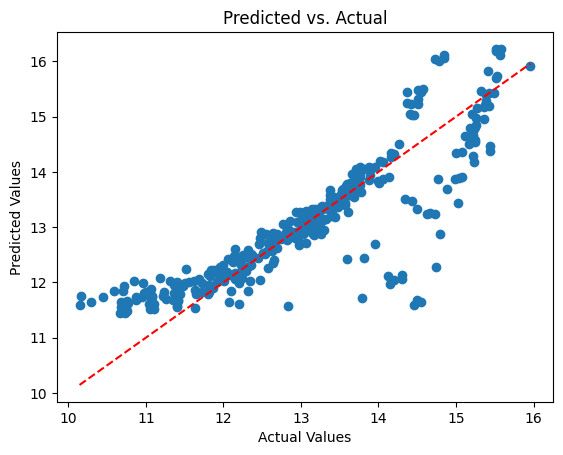

In [ ]:
plt.scatter(y_test, y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', color='red')  # Diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual")
plt.show()

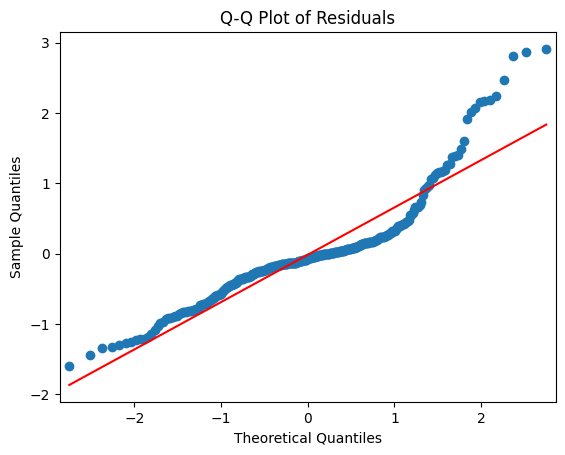

In [ ]:
import statsmodels.api as sm
residuals = y_test - y_pred_test
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Conclusion

Using the two plots above we can see that the points or not normally distributed well enough. The plot of actual vs. predicted is not 1:1, meaning y=x there are more errors as the actual values get higher. The model is conservative and shows predictions which are much lower than the actual values. This means the model is underfitting or giving costs which are lower than what patients are paying. The Q-Q plot confirms this, although the model does give a close prediction to lower quantiles, it quickly falls off when the quantiles get higher. The model predicts costs which are lower, which means the model's residuals have heavier tail than a normally distributed one. The model is underestimating the full complexity of patients with higher medical costs as the sample quantile values are higher than what is there in theory. To improve the model's accuracy we should look at alternative approaches like making non-linear or polynomial regression model. Experimenting with a new model like X^1.5 or X^2 might help make closer predictions for higher costs, or just making new assumptions and testing the whole model again might help. More accurate models are recommended to help save hospital costs and predict with better accuracy.